In [2]:
import os
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict

import matplotlib.pyplot as plt

import pickle
import warnings

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import mannwhitneyu, spearmanr
from sklearn.base import clone
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedKFold

from metaorf.modeling.etl import generate_orf_id, load_features, load_truth_datasets
from metaorf.modeling.ensemble import Dataset, plot_roc_pr, plot_roc, plot_pr

from pathlib import Path

pd.set_option('display.max_columns', 100)

warnings.filterwarnings('ignore')

In [4]:
data_dir = Path('../data').absolute()

def download_feature_set(experiment_name, local_path):
    orf_path = f"s3://velia-piperuns-dev/{experiment_name}/output/{experiment_name}_orf_features.csv"
    local_path = f"{local_path}/{experiment_name}_orf_features.csv"
    cmd = f"aws s3 cp {orf_path} {local_path}"
    print(cmd)
    os.system(cmd)
    return local_path

for experiment_name in open(f"{data_dir}/experiments.txt"):
    experiment_name = experiment_name.strip().strip("/")
    download_feature_set(experiment_name, data_dir)

### Load truth datasets

In [3]:
truth_df = shuffle(pd.read_csv("s3://velia-piperuns-dev/summary/truthset_batch1to4_240411_2.txt", sep='\t'))
truth_df['orf_id'] = truth_df.apply(lambda x: generate_orf_id(x), axis=1)

In [4]:
batch3 = [name for name in set(truth_df["ORF.type"]) if (name.startswith("batch3"))]
truth_df = truth_df[~ truth_df["ORF.type"].isin(batch3)]

In [5]:
datasets = load_truth_datasets(truth_df, data_dir, overwrite=True, dataset_names=['iPSC', 'MB1', 'Gaertner'])

In [6]:
dataset_name = 'all'
ds = copy.deepcopy(datasets[dataset_name])

In [7]:
sum(ds.y), len(ds.y)

(8675, 100797)

In [8]:
#ds.X = ds.X.drop(columns=["bigprot_id", "size_peak_frac", "size_gini", "periodicity_score",
#                         "pos_1_vs_0", "pos_2_vs_0", "frames_1_vs_0", "frames_2_vs_0"])
ds.X = ds.X.drop(columns=["bigprot_id"])
ds.X

,chrom_id,mean,sum,std,n_reads_orf_vs_genome,pos_1_vs_0,pos_2_vs_0,frames_1_vs_0,frames_2_vs_0,periodicity_first_60_1_vs_0,periodicity_first_60_2_vs_0,periodicity_last_60_1_vs_0,periodicity_last_60_2_vs_0,n_empty_codons,longest_empty_length_whole,longest_empty_length_first_30,longest_empty_length_last_30,five_utr_vs_cds_mean,five_utr_vs_cds_max,five_utr_vs_start_codon_mean,five_utr_vs_start_codon_max,cds_utr_vs_start_codon_mean,cds_utr_vs_start_codon_max,three_utr_vs_cds_mean,three_utr_vs_cds_max,three_utr_vs_stop_codon_mean,three_utr_vs_stop_codon_max,cds_utr_vs_stop_codon_mean,cds_utr_vs_stop_codon_max,dist_neg_100,dist_neg_150,dist_pos_100,dist_pos_150,five_utr_periodicity,five_utr_in_frame_bins,three_utr_periodicity,three_utr_in_frame_bins,price,ribotish,ribocode,tis_transformer_score,size_peak_frac,size_gini,periodicity_score
0,chr1,1.280714,-1.296777,0.097380,0.986014,0.000000,0.181818,0.150407,0.282520,0.115044,0.247788,0.208955,0.358209,-1.176091,-1.146128,-0.778151,-0.903090,1.038491,1.000000,1.085629,0.564271,5.551732e-02,-0.435729,2.064655,1.146128,1.799341,0.301030,-0.276206,-0.845098,-1.778151,-1.778151,-1.079181,-1.079181,1.800000,0.1,0.000000,0.0,999.000000,29.838859,24.775366,0.651046,0.688450,0.683772,0.683194
1,chr1,1.022905,-1.661042,0.165785,1.000000,0.000000,0.000000,0.175318,0.422135,0.211538,0.506410,0.131868,0.357143,-0.845098,-1.176091,-0.845098,-0.698970,0.528212,0.685397,0.046344,-0.511883,-5.278611e-01,-1.197281,1.548616,0.716003,1.780857,0.447158,0.249644,-0.268845,-0.477121,-1.000000,-0.845098,-0.845098,2.000000,0.2,0.000000,0.1,999.000000,31.557925,0.000000,0.000013,0.688450,0.683772,0.683194
2,chr1,0.334147,-2.046064,0.782222,0.992726,0.044177,0.056225,0.131786,0.350056,0.112513,0.170347,0.131657,0.479290,-0.000000,-0.698970,-0.301030,-0.602060,1.690213,1.551101,2.059791,1.551101,4.795247e-01,0.108398,1.352243,1.385351,1.902003,1.385351,0.615996,0.355388,-1.778151,-1.778151,-1.778151,-1.778151,2.000000,0.1,1.090909,0.3,14.680228,0.000000,21.813229,0.803072,0.688450,0.683772,0.683194
3,chr1,0.562122,-2.175071,0.465696,1.000000,0.059524,0.232143,0.132224,0.369608,0.118980,0.281870,0.125313,0.393484,-0.602060,-0.954243,-0.477121,-0.698970,1.385719,1.459895,1.779973,1.447158,5.171589e-01,-0.012737,1.779065,0.903090,1.276462,0.051153,-0.518839,-0.851937,-1.778151,-1.778151,-0.778151,-1.778151,0.857143,0.2,0.000000,0.1,999.000000,0.000000,46.479948,0.940670,0.688450,0.683772,0.683194
4,chr1,1.124113,-1.565196,0.132066,0.977578,0.000000,2.000000,0.151270,0.359122,0.000000,0.444444,0.159664,0.235294,-1.505150,-1.934498,-1.414973,-1.041393,0.000000,3.000000,3.000000,3.000000,8.293038e-01,-0.352183,0.964284,0.970037,1.502675,0.970037,0.602060,0.066947,-1.778151,-1.778151,-0.301030,-0.301030,0.000000,0.0,0.833333,0.3,999.000000,24.803012,30.264793,0.236586,0.688450,0.683772,0.683194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100792,chr6,1.344314,-1.240018,0.100536,0.994643,0.000000,0.000000,0.097902,0.200466,0.111111,0.152778,0.060606,0.212121,-1.544068,-1.462398,-1.230449,-1.255273,1.322957,0.636822,1.153815,0.301030,-1.918855e-01,-0.335792,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,-1.778151,-1.778151,-1.380211,-1.518514,0.000000,0.1,0.000000,0.0,0.000000,0.000000,20.832104,0.000680,0.649214,0.808236,0.747891
100793,chr6,1.334856,-0.722049,0.086808,1.000000,0.000000,0.000000,0.130435,0.339130,0.111111,0.152778,0.148936,0.595745,-0.903090,-1.414973,-1.230449,-1.000000,1.925017,1.113943,1.755875,0.778151,-1.918855e-01,-0.335792,3.000000,3.000000,3.000000,3.000000,-0.034762,-0.477121,-1.778151,-1.778151,-1.380211,-1.518514,0.000000,0.1,0.000000,0.0,0.000000,0.000000,6.687261,0.001726,0.649214,0.808236,0.747891
100794,chr8,1.394687,-1.383464,0.090714,1.000000,1.000000,1.000000,0.051128,0.114286,0.021277,0.053191,0.024390,0.109756,-1.716003,-1.431364,-1.079181,-1.

### Choose model

#### Gradient boosting classifier (standard)

In [9]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 8, 10],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 0.1, 0.2, 0.5],
    'subsample': [0.4, 0.6, 0.8, 1.0],
    'loss': ['deviance', 'exponential'],
}

def StratifiedByChrom(X):
    groups = [['chr1', 'chr6', 'chr11', 'chr16'],
            ['chr2', 'chr7', 'chr12', 'chr17'],
            ['chr3', 'chr8', 'chr13', 'chr18', 'chrX'],
            ['chr4', 'chr9', 'chr14', 'chr19'],
            ['chr5', 'chr10', 'chr15', 'chr20', 'chr21', 'chr22', 'chrY']]

    for group_idx in range(len(groups)):
        train_indice = X[~X["chrom_id"].isin(groups[group_idx])].index
        test_indice = X[X["chrom_id"].isin(groups[group_idx])].index
        yield (train_indice.values, test_indice.values)

cv = StratifiedByChrom(ds.X)
gclf = RandomizedSearchCV(GradientBoostingClassifier(), param_grid, random_state=0, n_jobs=72, n_iter=100, cv=cv)
search = gclf.fit(ds.X.drop(columns=["chrom_id"]).values, ds.y)
search.best_params_
classifier = GradientBoostingClassifier(**search.best_params_)

In [10]:
search.best_params_

{'subsample': 0.8,
 'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 0.2,
 'max_depth': 10,
 'loss': 'exponential',
 'learning_rate': 0.1}

In [9]:
best_params = {'subsample': 0.8,
 'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 0.2,
 'max_depth': 10,
 'loss': 'exponential',
 'learning_rate': 0.1}

In [10]:
classifier = GradientBoostingClassifier(**best_params)
classifier_type = 'gb'

In [11]:
ds.model = classifier

In [12]:
with open(f'../data/top_model_{dataset_name}_gb.pkl', 'wb') as file:
    pickle.dump(ds, file)

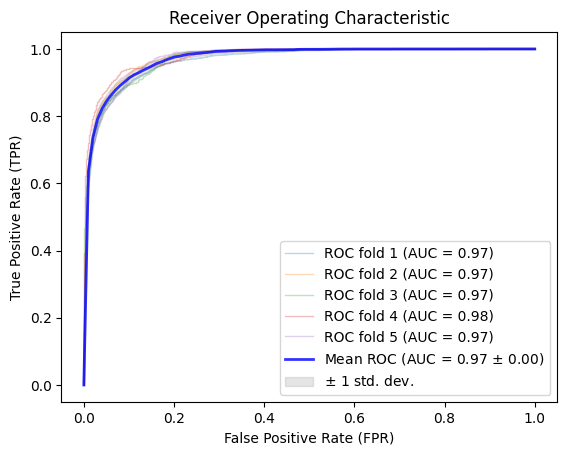

In [13]:
feature_importances, roc_pr_fig = plot_roc(ds, classifier)
roc_pr_fig.savefig(f'../figures/roc_curve_{ds.name}_{classifier_type}.png', dpi=200, bbox_inches='tight')

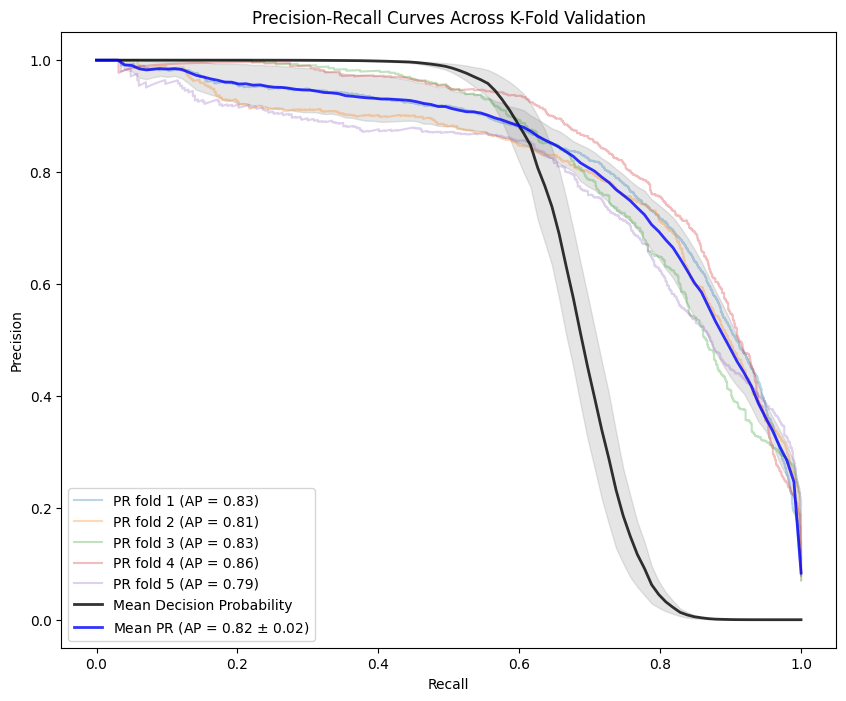

In [14]:
feature_importances, pr_fig = plot_pr(ds.X, ds.y, classifier, n_splits=5)
pr_fig.savefig(f'../figures/pr_curve_{ds.name}_{classifier_type}.png', dpi=200, bbox_inches='tight')

In [ ]:
closest_model, feature_importances, fig = plot_roc_pr(ds.X, ds.y, classifier, n_splits=5)
fig.savefig(f'../figures/roc_pr_threshold_{dataset_name}_gb.png', dpi=200, bbox_inches='tight')

In [ ]:
fi_df = pd.DataFrame(feature_importances, columns=ds.X.drop(columns=['chrom_id']).columns)
medians = fi_df.median()
sorted_columns = medians.sort_values(ascending=False).index
sorted_df = fi_df[sorted_columns]
plot_df = fi_df.melt(var_name='Category', value_name='Value')

In [ ]:
bplot = sns.boxplot(plot_df, y='Category', x='Value', order=sorted_df.columns)
bplot.figure.set_size_inches(5,7)
bplot.figure.savefig(f'../figures/feature_importance_impurity_{dataset_name}_{classifier_type}.png', dpi=200, bbox_inches='tight')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(ds.X).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=ds.X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()